## Calls

In [24]:
from pymongo import MongoClient

import time

MONGO_HOST="localhost"
MONGO_USER="root"
MONGO_PASSWORD="password"
MONGO_PORT=27017

address = 'mongodb://{user}:{password}@{host}:{port}'.format(
    user= MONGO_USER,
    password= MONGO_PASSWORD,
    host= MONGO_HOST,
    port= MONGO_PORT,
)

client = MongoClient(address)
database=client["observertc-reports"]

# the collection we want to query
reportsDatabase = database.reports

# print('connected to %s' % address)

cursor = reportsDatabase.find( { "type": "CALL_EVENT", "payload.name": { "$in": ["CLIENT_JOINED", "CLIENT_LEFT"] } } )

rooms = {}
for record in cursor:
    callEvent = record["payload"]

    roomId = callEvent["roomId"]
    callId = callEvent["callId"]
    userId = callEvent['userId']
    clientId = callEvent['clientId']
    timestamp = callEvent['timestamp']

    calls = rooms.get(roomId, {})
    clients = calls.get(callId, {})
    client = clients.get(clientId, {
        "clientId": clientId,
        "userId": userId,
        "callId": callId,
        "roomId": roomId,
    })
    
    if callEvent["name"] == "CLIENT_JOINED":
        client.update({ "joined": timestamp })
    else:
        client.update({ "left": timestamp })
    
    clients[clientId] = client
    calls[callId] = clients
    rooms[roomId] = calls

for room in rooms.items():
    roomId, calls = room
    print('\nRoom: %s\n--------' % roomId)
    for call in calls.items():
        callId, clients = call
        print('\nCall %s' % callId)
        for client in clients.values():
            userId, clientId, joined = client["userId"], client["clientId"], client["joined"]
            left = client.get("left", int(time.time() * 1000))
            duration = (left - joined) / (60 * 1000)
            print('\n\tUserId: %s \n\tClientId: %s\n\tJoined: %d\n\tLeft: %d\n\tDuration: %d min' % 
                  (userId, clientId, joined, left, duration))


Room: Santo Domingo
--------

Call ae2b890e-4c67-4947-9448-9b074ee947a7

	UserId: Peeves 
	ClientId: 64aeee1c-b6b6-43d4-a076-80cc1377d174
	Joined: 1654800562698
	Left: 1654801764402
	Duration: 20 min

	UserId: Bellatrix Lestrange 
	ClientId: e6c57372-08c8-4853-9cb3-912daadd3e20
	Joined: 1654801711505
	Left: 1654801784404
	Duration: 1 min

Call 3f7c39a9-1ae5-4d9f-a6e5-5f467d367ce3

	UserId: Hedwig 
	ClientId: bf7b9ea1-d2c5-4762-93d8-33a3a9729bcd
	Joined: 1654803322051
	Left: 1654858214687
	Duration: 914 min

	UserId: Dumbledore 
	ClientId: 89c82d9d-d9a9-4d82-bcb7-82fe9eec4811
	Joined: 1654803326351
	Left: 1654858214687
	Duration: 914 min

	UserId: Bellatrix Lestrange 
	ClientId: dff1e8a7-9633-49ca-9e9b-19f6e52a9931
	Joined: 1654803329499
	Left: 1654858214687
	Duration: 914 min

Room: Washington, D.C.
--------

Call 84f0aacc-b135-42ad-932f-b7b010a5754c

	UserId: Seamus Finnigan 
	ClientId: d0b47c12-969f-4681-836a-143f4fd27d66
	Joined: 1654803655203
	Left: 1654803965004
	Duration: 5 min


## Select the call and the client we want to plot the end-to-end RTTs

In [25]:
CALL_ID = "84f0aacc-b135-42ad-932f-b7b010a5754c"
CLIENT_ID = "a7ed9d5d-d6e4-49dc-8637-ba836fc04165"

# print("selected call is ", CALL_ID, "in room", clients[CLIENT_ID]["roomId"], "selected user is ", clients[CLIENT_ID]["userId"])



### Collect peer connections RTT measurements

In [26]:
peer_connection_rtts = {}

stage_match = {
    "$match": {
        "$or": [{ "type": "OUTBOUND_VIDEO_TRACK" }, { "type": "OUTBOUND_AUDIO_TRACK" }], 
        "payload.callId": CALL_ID,
   }
}

pipeline = [
   stage_match, 
]

cursor = reportsDatabase.aggregate(pipeline)
for report in cursor:
    payload = report["payload"]
    peerconnection_id = payload["peerConnectionId"]
    rtt_in_s = payload["roundTripTime"]
    timestamp = payload["timestamp"]
    
    measurements = peer_connection_rtts.get(peerconnection_id, [])
    measurement = (rtt_in_s, timestamp)
    measurements.append(measurement)
    peer_connection_rtts[peerconnection_id] = measurements
    


### Collect Client peer connections

In [27]:
# map client ids to its peer connections subscribed to receive inbound tracks
client_inb_pc_ids = {}

# peer connections to its remote peer connections and clients
inb_pc_outb_pairs = {}

# have an inner map for every client map remote client to the peer connection sending outbound tracks
client_outb_pc_pairs = {}

stage_match = {
    "$match": {
        "$or": [{ "type": "INBOUND_VIDEO_TRACK" }, { "type": "INBOUND_AUDIO_TRACK" }],
        "payload.callId": CALL_ID,
   }
}
pipeline = [
   stage_match,
]

cursor = reportsDatabase.aggregate(pipeline)
for report in cursor:
    payload = report["payload"]
    client_id = payload["clientId"]
    client_peerconnection_id = payload["peerConnectionId"]
    remote_client_id = payload["remoteClientId"]
    remote_client_peerconnection_id = payload["remotePeerConnectionId"]


    if client_peerconnection_id is not None:
        inb_pc_ids = client_inb_pc_ids.get(client_id, set())
        inb_pc_ids.add(client_peerconnection_id)
        client_inb_pc_ids[client_id] = inb_pc_ids

        if remote_client_id is not None and remote_client_peerconnection_id is not None:
            inb_pc_outb_pairs[client_peerconnection_id] = (remote_client_peerconnection_id, remote_client_id)
            
            client_remote_peers = client_outb_pc_pairs.get(remote_client_id, {})
            client_remote_peers[client_id] = remote_client_peerconnection_id
            client_outb_pc_pairs[client_id] = client_remote_peers



### Calculate Client end-to-end RTTs

In [28]:
client_to_client_rtts = {}

for client_inb_pc_id in client_inb_pc_ids[CLIENT_ID]:
    
    remote_pc_id, remote_client_id = inb_pc_outb_pairs[client_inb_pc_id]
    remote_measurements = peer_connection_rtts[remote_pc_id]

    remote_client_peers = client_outb_pc_pairs[remote_client_id]
    client_outb_pc_id = remote_client_peers[CLIENT_ID]
    local_measurements = peer_connection_rtts[client_outb_pc_id]
    
    sorted_local_measurements = sorted(local_measurements, key=lambda x: x[1])
    sorted_remote_measurements = sorted(remote_measurements, key=lambda x: x[1])
    
    i, j, loc_size, rem_size = 0, 0, len(sorted_local_measurements), len(sorted_remote_measurements)
    
    end_to_end_rtts = []
    timestamps = []
    while True:
        if loc_size <= i or rem_size <= j:
            break
        
        local_client_to_sfu_rtt, local_client_actual_ts = sorted_local_measurements[i]
        remote_client_to_sfu_rtt, remote_client_actual_ts = sorted_remote_measurements[j]
        
        if  i + 1 < loc_size and sorted_local_measurements[i + 1][1] < remote_client_actual_ts:
            i = i + 1
            continue
        
        if j + 1 < rem_size and sorted_remote_measurements[j + 1][1] < local_client_actual_ts:
            j = j + 1
            continue
        
        end_to_end_rtt = local_client_to_sfu_rtt + remote_client_to_sfu_rtt
        ts = max(local_client_actual_ts, remote_client_actual_ts)
        
        end_to_end_rtts.append(end_to_end_rtt)
        timestamps.append(ts)
        
        i = i + 1
        j = j + 1

    client_to_client_rtts[remote_client_id] = (timestamps, end_to_end_rtts)

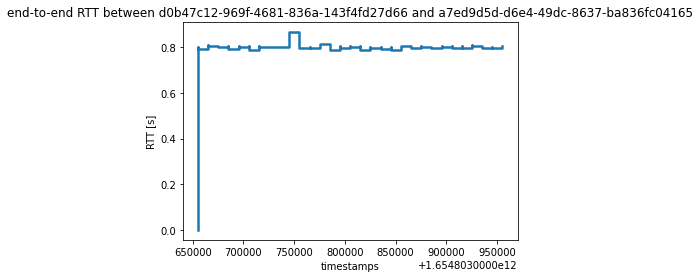

In [29]:
import matplotlib.pyplot as plt

for remote_client_id, remote_client_rtts in client_to_client_rtts.items():
    x, y = remote_client_rtts
    fig, ax = plt.subplots()
    
#     remote_client = clients[remote_client_id]
#     ax.set_title("end-to-end RTT between " + client["userId"] + " and " + remote_client["userId"])
    ax.set_title("end-to-end RTT between " + remote_client_id + " and " + CLIENT_ID)
    ax.step(x, y, linewidth=2.5)
    ax.set_xlabel('timestamps')
    ax.set_ylabel('RTT [s]')
    plt.show()